In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE


In [2]:
df = pd.read_csv("diabetes_prediction_dataset.csv")

In [3]:
print(df.shape)       
print(df.dtypes)        
print(df.head()) 

(100000, 9)
gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object
   gender   age  hypertension  heart_disease smoking_history    bmi   
0  Female  80.0             0              0         No Info  10.01  \
1    Male   8.0             0              0         No Info  10.01   
2    Male  38.0             0              0           never  10.08   
3    Male  11.0             0              0         No Info  10.14   
4    Male  39.0             0              0            ever  10.19   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.0                  100         0  
1          6.0                  140         0  
2          6.1                  130         0  
3          6.1                  160         0  
4          6.5              

In [4]:
# Check for the Duplicates
n_dup = df.duplicated().sum()
print("Duplicated Number:", n_dup)

# Check for the missing value
miss_cnt = df.isna().sum()
miss_pct = (df.isna().mean() * 100).round(2)
print("\nNumber of missing value:\n", miss_cnt)
print("\nMissing value proportion:\n", miss_pct)

# 3. Check for the distributions:
print("\nGender distribution:\n", df['gender'].value_counts(dropna=False))
print("\nSmoking_history distribution:\n", df['smoking_history'].value_counts(dropna=False))

print("\nage: \n", df['age'].describe())
print("\nbmi: \n", df['bmi'].describe())
print("\nHbA1c_level: \n", df['HbA1c_level'].describe())
print("\nblood_glucose_level: \n", df['blood_glucose_level'].describe())


Duplicated Number: 3854

Number of missing value:
 gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Missing value proportion:
 gender                 0.0
age                    0.0
hypertension           0.0
heart_disease          0.0
smoking_history        0.0
bmi                    0.0
HbA1c_level            0.0
blood_glucose_level    0.0
diabetes               0.0
dtype: float64

Gender distribution:
 gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

Smoking_history distribution:
 smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

age: 
 count    100000.000000
mean         41.885856
std          22.516840
min           0.080000
25%          24.00000

In [5]:
#1.1 eliminate duplicates
df = df.drop_duplicates()

#1.2 remove gender = other
df = df[df['gender'] != 'Other'].reset_index(drop=True)

gender_encoder = LabelEncoder()
df['gender'] = gender_encoder.fit_transform(df['gender'])

#1.2 replace Smoking_History: No Info to NAN
df['smoking_history'] = df['smoking_history'].replace('No Info', np.nan)

#grouping
df['smoking_history'] = df['smoking_history'].replace({ 'ever':    'former', 'not current': 'former'})

df['smoking_history'] = df['smoking_history'].fillna('Unknown')

smoking_history_encoder = LabelEncoder()
df['smoking_history'] = smoking_history_encoder.fit_transform(df['smoking_history'])




In [6]:
print(df.shape)         
print(df.dtypes)      
print(df.head()) 

(96128, 9)
gender                   int64
age                    float64
hypertension             int64
heart_disease            int64
smoking_history          int64
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object
   gender   age  hypertension  heart_disease  smoking_history    bmi   
0       0  80.0             0              0                0  10.01  \
1       1   8.0             0              0                0  10.01   
2       1  38.0             0              0                3  10.08   
3       1  11.0             0              0                0  10.14   
4       1  39.0             0              0                2  10.19   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.0                  100         0  
1          6.0                  140         0  
2          6.1                  130         0  
3          6.1                  160         0  
4          6.5         

In [7]:
numeric_cols = ['age','bmi','HbA1c_level','blood_glucose_level']
outlier_counts = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask = (df[col] < lower) | (df[col] > upper)
    outlier_counts[col] = mask.sum()

print("Outliner number: ", outlier_counts)
print("Outliner proportion: ", {col:cnt/len(df)*100  for col,cnt in outlier_counts.items()})

Outliner number:  {'age': 0, 'bmi': 5354, 'HbA1c_level': 1312, 'blood_glucose_level': 2031}
Outliner proportion:  {'age': 0.0, 'bmi': 5.569657123834887, 'HbA1c_level': 1.3648468708388815, 'blood_glucose_level': 2.1128079227696404}


In [8]:
feature_cols = ['gender','smoking_history','age','hypertension','heart_disease','bmi','HbA1c_level','blood_glucose_level']
X = df[feature_cols]
y = df['diabetes']


In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(
    n_splits=1,     
    test_size=0.2
)

for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Check the proportion
print("Oringinal proportion: ", y.mean())
print("Training set proportion: ", y_train.mean())
print("Testing set proportion: ", y_test.mean())

Oringinal proportion:  0.08823651797603196
Training set proportion:  0.08824217835686979
Testing set proportion:  0.0882138770415063


In [10]:
print("Training set size: ", X_train.shape, "Testing set size: ", X_test.shape)

Training set size:  (76902, 8) Testing set size:  (19226, 8)


In [11]:

# building RFCmodel
rf = RandomForestClassifier(
    n_estimators = 1000,   
    max_depth = 22,      
    min_samples_leaf = 8,  
    random_state = None,
    n_jobs = -1 ,
    class_weight = {0:1, 1:10}
)

In [12]:
#fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 10}, max_depth=22,
                       min_samples_leaf=8, n_estimators=1000, n_jobs=-1)

              precision    recall  f1-score   support

           0       0.98      0.95      0.97     17530
           1       0.61      0.85      0.71      1696

    accuracy                           0.94     19226
   macro avg       0.80      0.90      0.84     19226
weighted avg       0.95      0.94      0.94     19226

ROC AUC: 0.9758435000914872


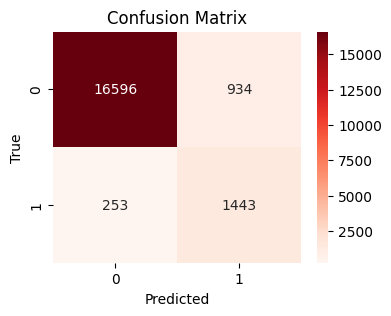

In [13]:
# Do the prediction
y_pred = rf.predict(X_test)

y_proba = rf.predict_proba(X_test)[:, 1]

# Output the classification report
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [14]:
"""
for depth in range(1, 30):

    rf = RandomForestClassifier(
    n_estimators = 1000,    
    max_depth = depth,    
    min_samples_leaf = 8,  
    random_state = None,
    n_jobs = -1 ,           
    class_weight = 'balanced')
    
    scores = cross_val_score(rf, X_train, y_train, cv=5) 
    print(f" Depth: {depth}, Average accuracy: {scores.mean():.4f}")
"""

'\nfor depth in range(1, 30):\n\n    rf = RandomForestClassifier(\n    n_estimators = 1000,    \n    max_depth = depth,    \n    min_samples_leaf = 8,  \n    random_state = None,\n    n_jobs = -1 ,           \n    class_weight = \'balanced\')\n    \n    scores = cross_val_score(rf, X_train, y_train, cv=5) \n    print(f" Depth: {depth}, Average accuracy: {scores.mean():.4f}")\n'

Best Parameter: {'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance'}
Best recall rate: 0.6475036438995749
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     17530
           1       0.79      0.66      0.72      1696

    accuracy                           0.95     19226
   macro avg       0.88      0.82      0.85     19226
weighted avg       0.95      0.95      0.95     19226

ROC AUC: 0.8801171374678447


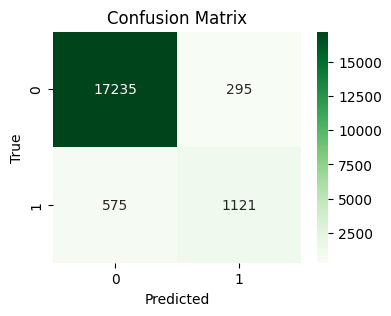

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold


# Pipeline construction
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Grid search for good parameter
param_grid = {
    'knn__n_neighbors': [3,5,7,9,11,13],
    'knn__weights': ['uniform','distance'],
    'knn__p': [1,2]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, cv=skf, scoring='recall', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameter:", grid.best_params_)
print("Best recall rate:", grid.best_score_)

best_knn = grid.best_estimator_
y_pred  = best_knn.predict(X_test)
y_proba = best_knn.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()